# Voxel Mapping for PDB structures

This script pulls structures from the PDB and then assigns each atom a 1A^3 cell (by rounding down) and then uses that to index a 3D numpy array, which is the final voxel map. Any value can be assigned to the array, including atomic descriptors. 

This version ignores cofactors

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from biopandas.pdb import PandasPdb # Turns PDB files into dataframes, really handy
import sklearn.preprocessing


def makevmap(prot):
    vmap = np.zeros([int(max(data['x_coord']+1)),int(max(data['y_coord']+1)),int(max(data['z_coord']+1))], dtype = np.int8)
    for i in prot:
        vmap[prot['x_coord'].astype(int),prot['y_coord'].astype(int),prot['z_coord'].astype(int)] = prot['element_symbol']
        return vmap
    
    
data = PandasPdb().fetch_pdb('1bu7') #### put your pdb accession number here

data = data.df['ATOM']
data = data[data['chain_id']=='A'] #Just in case there are multiple chains in the structure

#make positive numbers
data['x_coord'] = data['x_coord']-data['x_coord'].min()
data['y_coord'] = data['y_coord']-data['y_coord'].min()
data['z_coord'] = data['z_coord']-data['z_coord'].min()

#assign numbers to elements
encoder = sklearn.preprocessing.LabelEncoder()
data['element_symbol'] = encoder.fit_transform(data['element_symbol'])+1 #+1 so that there are no zeros


vmap = makevmap(data)

For machine learning, you should offset the magnitude of the encoded atoms by binary encoding them into separate vmaps, here is a key:

In [68]:
key = pd.DataFrame([pd.Series(encoder.inverse_transform(data['element_symbol'].unique()-1)),
             pd.Series(data['element_symbol'].unique())]).transpose()
key.columns =['Element', 'Encoding']
key = key.sort_values(['Encoding'])
key

C:\Users\MFBX3JE3\Anaconda35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Element,Encoding
1,C,1
0,N,2
2,O,3
3,S,4


# Split into the carbon, nitrogen etc voxelmaps
In a dictionary

In [133]:
d={}

for i in key['Element']:
    x = key['Encoding'].loc[key['Element'] == i].values
    d['vmap{0}'.format(i)]= (vmap ==x).astype(int)

# Visualisation

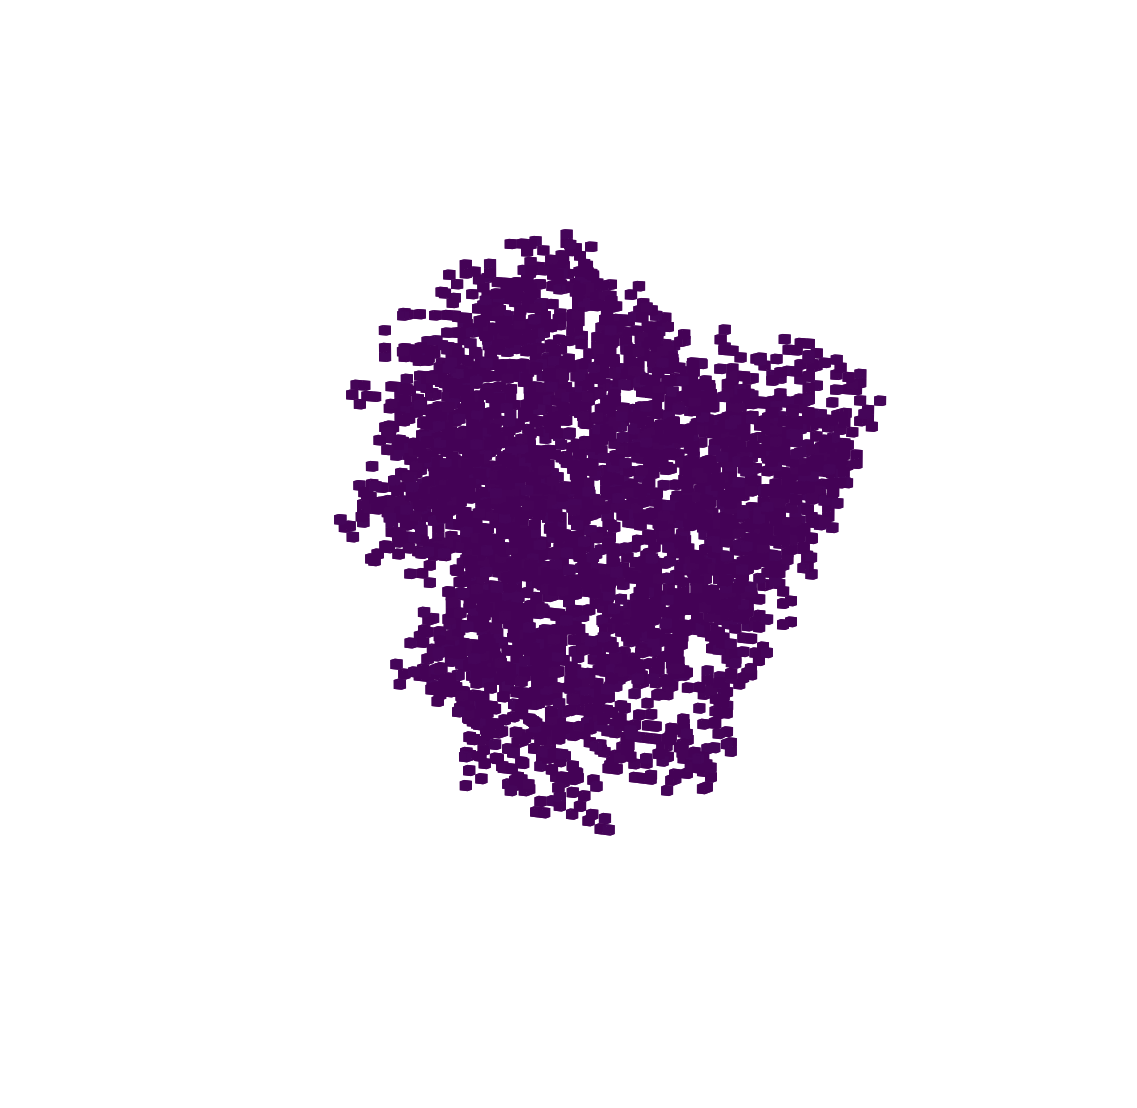

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


facecolors = cm.viridis(vmap)
                         
fig = plt.figure(figsize = (20,20))
ax = fig.gca(projection='3d')

ax.voxels(vmap, 
          edgecolor=None, 
          linewidth = 0.1, 
          facecolors=facecolors,
         alpha = 0.1)
ax.axis('off')
ax.view_init(10, 300)

plt.show()